# UDACITY RL NANODEGREE: project 1 Navigation

---

## Preamble

In this notebook, a DQN agent is used to solve a navigation problem as a first project for the  [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

Before using this notebook check that you have followed the .Readme file available in [GitHub Project repository](https://github.com/BDGITAI/RL_P1_Navigation/)

For the Notebook to work you will need the Banana environment executable which was placed in [GitHub Project repository](https://github.com/BDGITAI/RL_P1_Navigation/Banana_Windows_x86_64/). The environment needs to uncompressed in  `"../Banana_Windows_x86_64/Banana.exe"`

This DQN implementation uses the Pytorch library and was tested in a **Windows 64 bits** platform using **CPU**  computation. 


This notebook is divided in two parts
* **Part 1** : Training. We will train an Agent and see how the learning can be applied to execute a task
* **Part 2** : To see an already trained agent you can skip to Part 2 and load a trained agent.

---

## 1. Part 1 : Training an agent 

### 1.1 Imports
First we import the required libraries (including Unity and Pytorch)

In [ ]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt

# import agent class
from dqn_agent import Agent

%matplotlib inline

As mentioned above we import the Agent from the dqn_agent.
The agent used in this notebook is created using two files:

* **dqn_agent.py** : Contains the Agent and Buffer class for our agent
* **dqn_model.py** : Contains the Model class used to build our Qfunction

These files were built using the starter code provided by UDACITY during the Nanodegree lectures to solve a Lunar Lander Atari game.

### 1.2 Load environment
Then we load the untiy environment (runtime). Before running the cell check that you have the Banana.exe file placed in the correct folder

In [3]:
env = UnityEnvironment(file_name="../Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 1.3 Create Agent
Once the environment is loaded we can gather information about observation space and actions to initialise our Agent.
The Unity python API is described [here](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Python-API.md)



In [4]:
# The interface between the Unity environment and python is done through the use of a brain
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# get the current state to determine observation 
state = env_info.vector_observations[0]            
state_size = len(state)
action_size = brain.vector_action_space_size  

#create agent
agent = Agent(state_size, action_size, seed=0)

### 1.4Training Loop
Now we can train the agent and observe the score evolution.

Episode 100	Average Score: 1.06
Episode 200	Average Score: 4.71
Episode 300	Average Score: 8.63
Episode 400	Average Score: 11.05
Episode 500	Average Score: 13.47
Episode 554	Average Score: 14.03
Environment solved in 454 episodes!	Average Score: 14.03


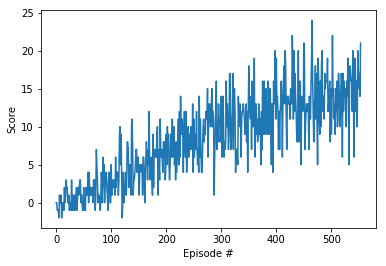

In [5]:
def train(n_episodes=20000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        # reset environment at the start of each episode
        env_info = env.reset(train_mode=True)[brain_name]
        # episode is not finished
        done = False
        # no reward at start
        episode_rewards = 0
        # get the first state of the episode
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            # decide wich action to take according to eps greedy policy
            action = agent.act(state, eps)
            # execute the action in the environment (interface with unity)
            env_info = env.step(np.int32(action))[brain_name] 
            # get what is the next state
            next_state = env_info.vector_observations[0]
            # get rewards for action
            reward = env_info.rewards[0]
            # check if game ends
            done = env_info.local_done[0]
            # store this experience in the memory and learn if enough experiences have been gathered
            agent.step(state, action, reward, next_state, done)
            # update current state as next state
            state = next_state
            # cumul rewrd
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        # save network weigth every 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            path = 'checkpoint_'+str(i_episode)+'.pth'
            torch.save(agent.qnetwork_local.state_dict(), path)
        # target is 13 to win. 14 average is chosen as a margin
        if np.mean(scores_window)>=14.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            path = 'checkpoint_'+str(i_episode)+'_score_'+str(np.mean(scores_window))+'.pth'
            torch.save(agent.qnetwork_local.state_dict(), path)
            break
    return scores,path

scores,weigth_path = train()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


### 1.5 Visualise a trained agent
In the previous section we saved the weight into a file and save the path into "weigth_path".
We can load these weigth into the QNetwork of our agent and see the results

In [6]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load(weigth_path))

for i in range(3):
    # disable training mode
    env_info = env.reset(train_mode=False)[brain_name]
    done = False
    score = 0
    state = env_info.vector_observations[0]
    while not done:
        action = agent.act(state)
        env_info = env.step(np.int32(action))[brain_name] 
        next_state = env_info.vector_observations[0]
        #next_state, reward, done, _ = env.step(action)
        done = env_info.local_done[0]
        reward = env_info.rewards[0]
        score += reward
        state = next_state
        if done:
            break 
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, score))
env.close()


Episode 0	Average Score: 16.00
Episode 1	Average Score: 18.00
Episode 2	Average Score: 15.00


## Part 2 : Watching an already trained agent 

In [7]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt

# import agent class
from dqn_agent import Agent

%matplotlib inline

In [8]:
env = UnityEnvironment(file_name="../Banana_Windows_x86_64/Banana.exe")
# The interface between the Unity environment and python is done through the use of a brain
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# get the current state to determine observation 
state = env_info.vector_observations[0]            
state_size = len(state)
action_size = brain.vector_action_space_size  
weigth_path = "./successful_weights/successful_weights.pth"
#create agent
agent = Agent(state_size, action_size, seed=0)

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load(weigth_path))

for i in range(3):
    # disable training mode
    env_info = env.reset(train_mode=False)[brain_name]
    done = False
    score = 0
    state = env_info.vector_observations[0]
    while not done:
        action = agent.act(state)
        env_info = env.step(np.int32(action))[brain_name] 
        next_state = env_info.vector_observations[0]
        #next_state, reward, done, _ = env.step(action)
        done = env_info.local_done[0]
        reward = env_info.rewards[0]
        score += reward
        state = next_state
        if done:
            break 
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, score))
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 0	Average Score: 16.00
Episode 1	Average Score: 15.00
Episode 2	Average Score: 12.00
